# Projeto ML - Titanic espacial:
Projeto de Machine Learning cujo objetivo é identificar quais membros da hipotética tripulação foram foram transportados para outra dimensão. A base de dados pertence a uma competição do Kaggle, no link: https://www.kaggle.com/competitions/spaceship-titanic

## Parte 1 - Carregamento dos dados:

### Importando bibliotecas:

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

### Importando classes e métodos:

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

### Carregando base de dados:

In [91]:
train_df = pd.read_csv(r'C:\Users\Thomas\Notebooks\Planilhas\spaceship-titanic\train.csv')

In [159]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Entendendo o problema:

A ideia do projeto é utilizar um modelo de machine learning para classificar se um indivíduo foi transportado ou não. A coluna **"Transported"** é responsável por definir se alguém foi transportado ou não, sendo essa a coluna target do projeto, os dados restantes serão trabalhados e preparados para alimentar um modelo de classificação que consiga identificar as relações entre as features e o target.

## Parte 2 - Exploração dos dados:

### Conhecendo a base de dados:

#### Proporções:

In [160]:
print(f'O dataframe tem {train_df.shape[0]} linhas e {train_df.shape[1]} colunas')

O dataframe tem 8693 linhas e 14 colunas


O dataframe não é muito grande, pois tem menos de 10 mil linhas. Já as colunas devem ser analisadas com atenção, pois 14 colunas podem se multiplicar durante a preparação dos dados para modelagem.

#### Estatísticas descritivas:

In [161]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


É possível perceber uma grande disparidade entre as distribuições de valores, havendo uma variação gigante no último quartil enquanto os outros são basicamente populados unicamente por valores nulos, sendo esse padrão recorrente em todas as colunas com excessão de **"Age"**. Portanto as medidas sensíveis a outliers são inutilizáveis visto que representarão apenas os valores do último quartil. 

In [162]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


É possível perceber o equilíbrio entre a quantidade de features categóricas e numéricas.

#### Target:

In [163]:
target = train_df['Transported'].value_counts()
print(f'Há {target[0]} valores verdadeiros e {target[1]} valores falsos')

Há 4315 valores verdadeiros e 4378 valores falsos


A proporção entre True and False na coluna target é equilibrada.

#### Identificando os valores nulos:

In [164]:
missing_values = train_df.isna().sum()/len(train_df)
lista_missing_values = missing_values.index.to_list()

In [165]:
for coluna in lista_missing_values:
    print(f'A coluna {coluna} tem {round(missing_values[coluna],3)}% dos valores faltando')

A coluna PassengerId tem 0.0% dos valores faltando
A coluna HomePlanet tem 0.023% dos valores faltando
A coluna CryoSleep tem 0.025% dos valores faltando
A coluna Cabin tem 0.023% dos valores faltando
A coluna Destination tem 0.021% dos valores faltando
A coluna Age tem 0.021% dos valores faltando
A coluna VIP tem 0.023% dos valores faltando
A coluna RoomService tem 0.021% dos valores faltando
A coluna FoodCourt tem 0.021% dos valores faltando
A coluna ShoppingMall tem 0.024% dos valores faltando
A coluna Spa tem 0.021% dos valores faltando
A coluna VRDeck tem 0.022% dos valores faltando
A coluna Name tem 0.023% dos valores faltando
A coluna Transported tem 0.0% dos valores faltando


A maioria das colunas tem uma porcentagem de cerca de 2% de valores faltando.

#### Separando as colunas por categoria:

In [92]:
categorical_cols = train_df.select_dtypes(include=object).columns.to_list()
print(f'As colunas categóricas são {categorical_cols}')

As colunas categóricas são ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


In [167]:
train_df[categorical_cols].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


In [93]:
numeric_cols = train_df.select_dtypes(include=np.number).columns.to_list()
print(f'As colunas numéricas são {numeric_cols}')

As colunas numéricas são ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [169]:
train_df[numeric_cols].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


### Visualizando os dados:

#### Distribuição dos dados:

##### Problema encontrado:
* As colunas numéricas fora **"Age"** possuem uma dispersão de dados muito grande, tornando os histogramas irrelevantes para a visualização dos dados, portanto será necessário fazer uma transformação nos dados, no caso será utilizada uma tranformação logarítimica 

##### Transformando as colunas dispersas:

In [170]:
visu_df = train_df.copy() # Copiando o dataframe para mudar os dados sem atrapalhar a modelagem

In [171]:
def zero_pra_1(number): #Função para tranformar os 0 em 1
    if number == 0:
        return 1
    else:
        return number

In [172]:
for index in range(1,6):
    visu_df[numeric_cols[index]] = visu_df[numeric_cols[index]].apply(zero_pra_1)  # Todos os zeros foram transformados em 1

##### Histogramas:

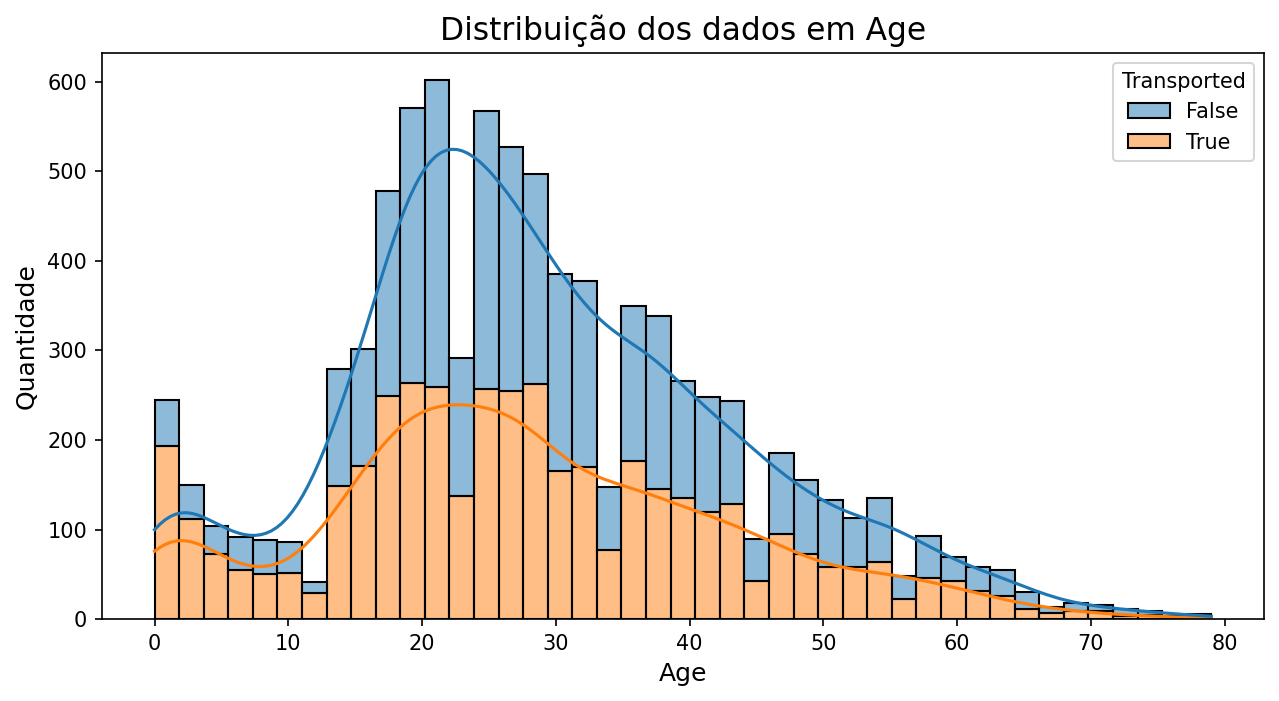

In [173]:
plt.figure(figsize = (10,5), dpi = 150)
sns.histplot(data = train_df,
             x = 'Age',
             kde = True,
             hue = 'Transported',
             multiple = 'stack')
plt.title('Distribuição dos dados em Age', fontsize=15)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.show()

É possível analisar que a idade não é um fator realmente relevante para definir se alguém foi transportado ou não, pois as distribuições de idade entre indivíduos transportados e não-transportados são muito semelhantes. Com exceção da idade de 0 anos, que apresenta uma quantidade maior de transportados do que não-transportados.

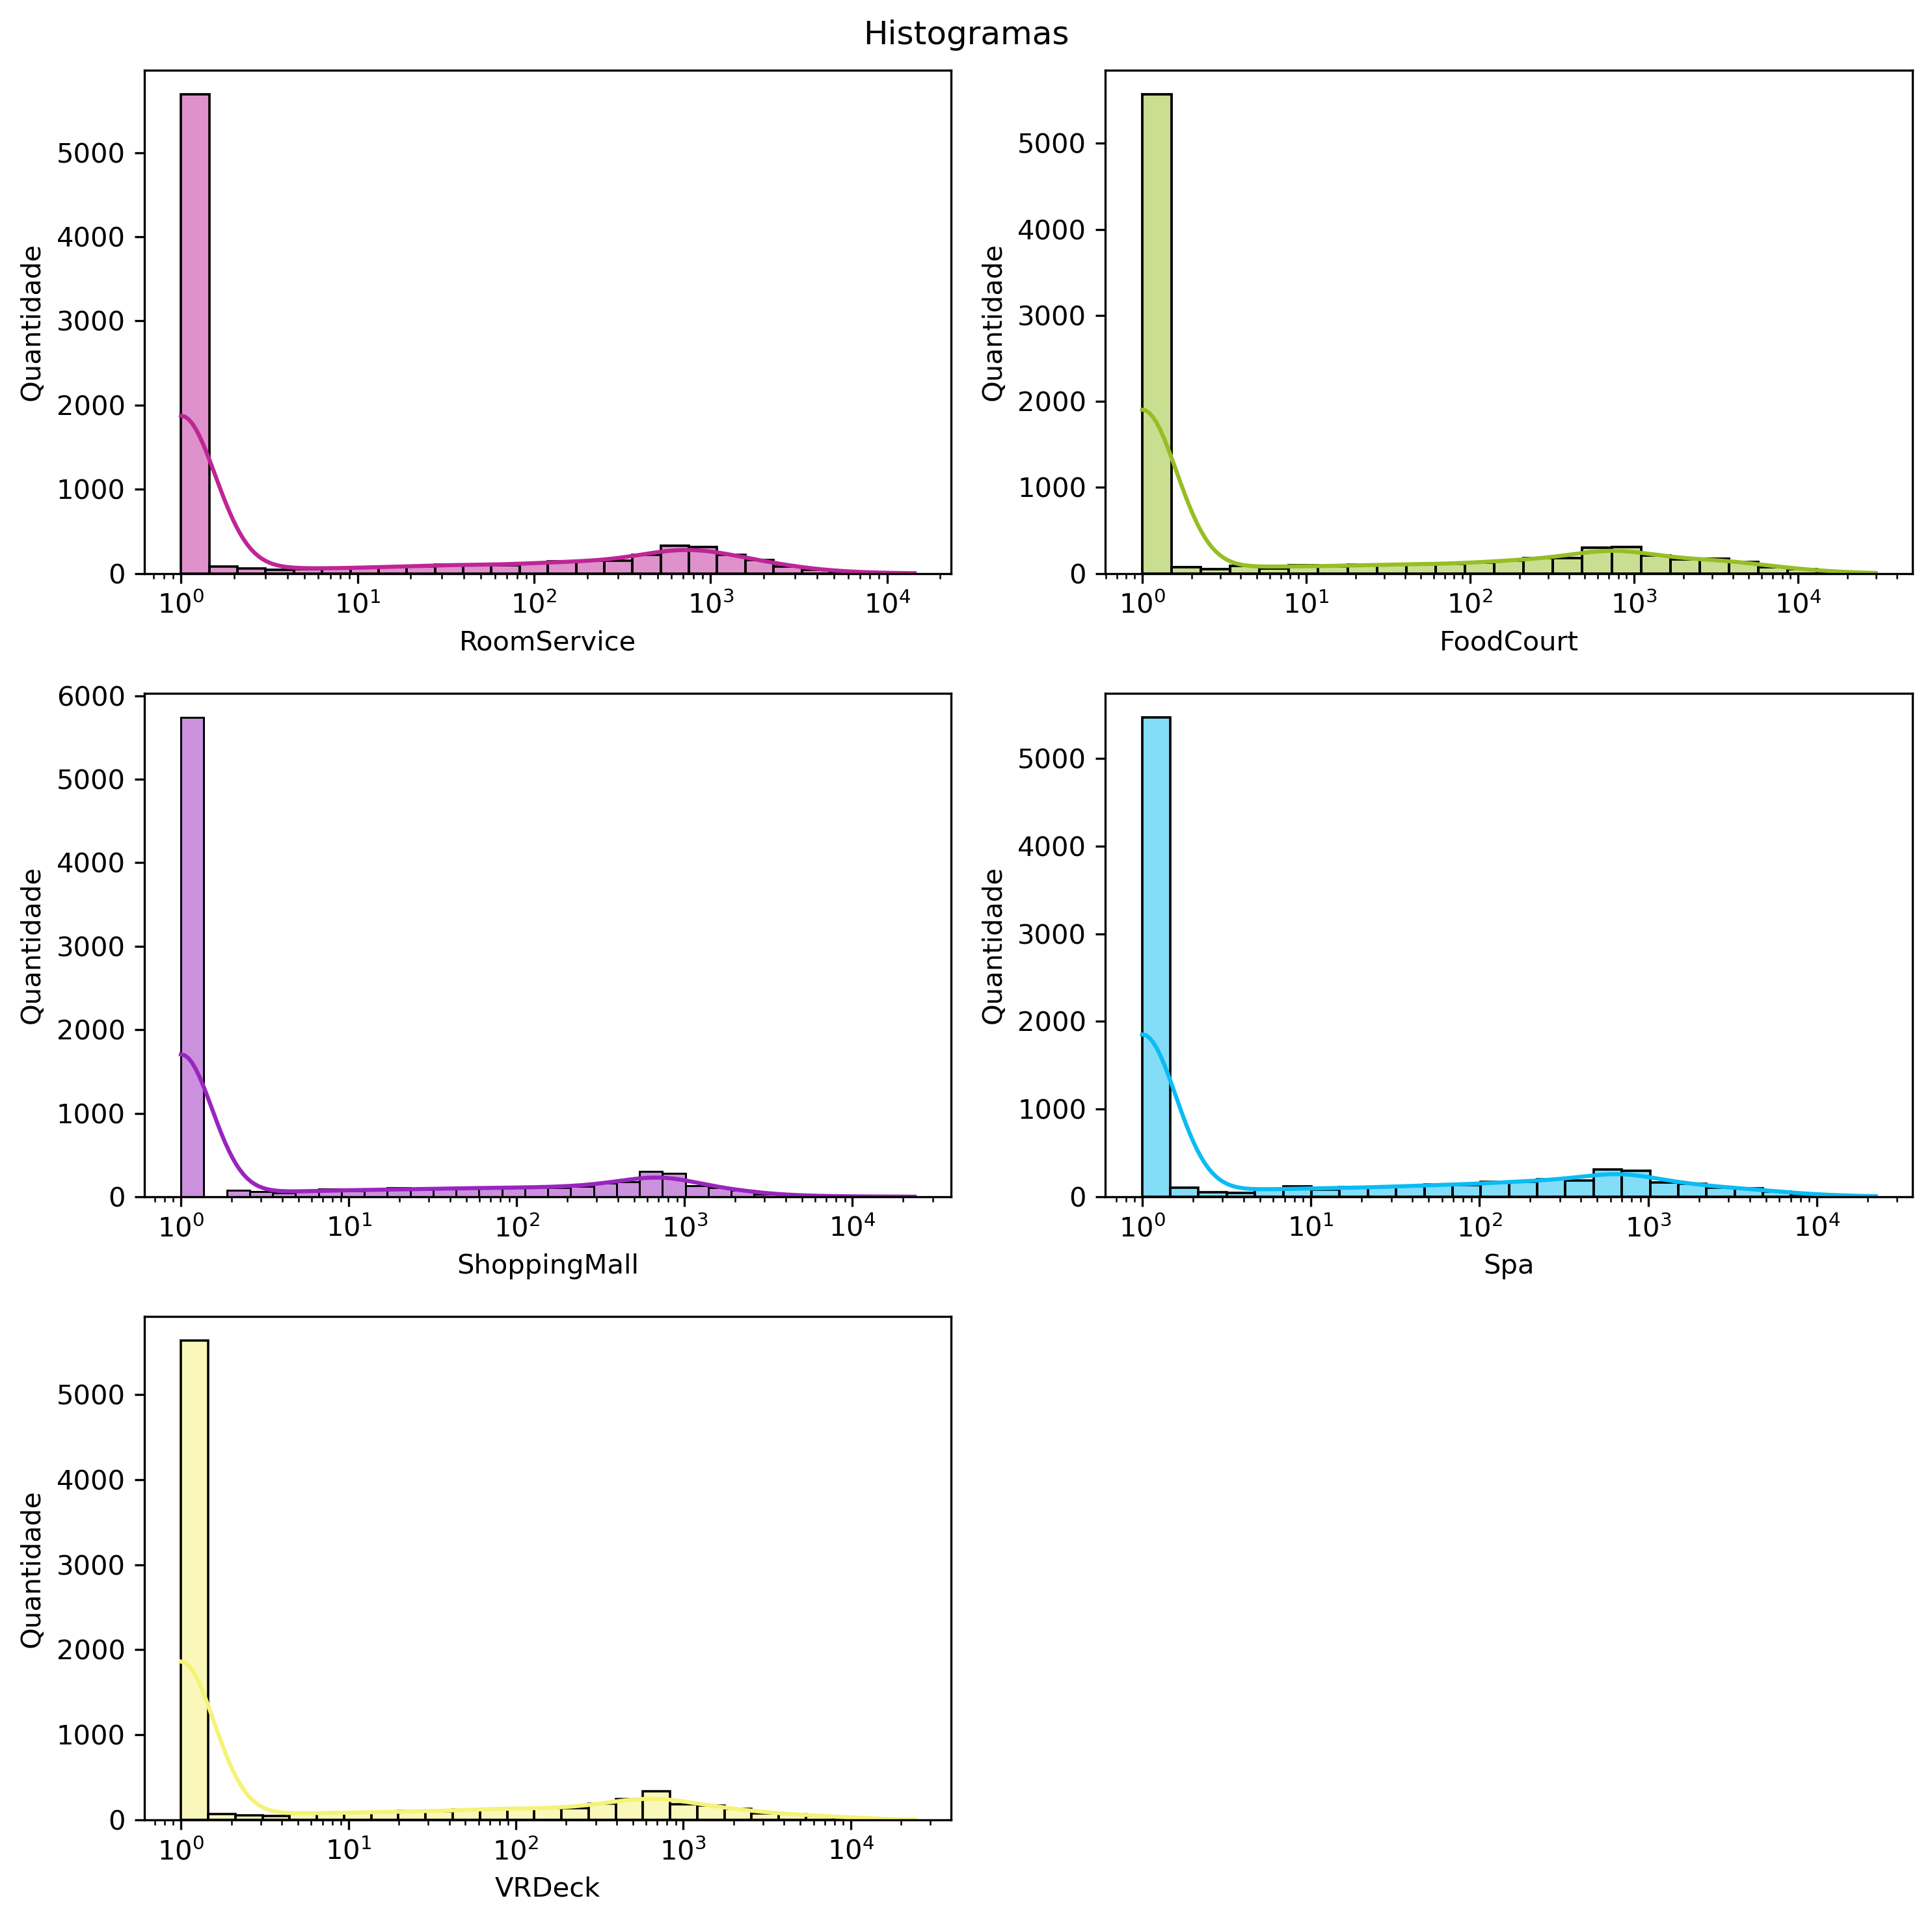

In [174]:
lista_de_cores = ['#be2596','#96be25','#9925be','#0abcf3','#F5f377']
lista_index = list(range(1,6))

plt.figure(figsize = (10,10),dpi = 300)
plt.suptitle('Histogramas')
for index,cor in zip(lista_index, lista_de_cores):
    plt.subplot(3,2,index)
    sns.histplot(data = visu_df, 
                 x = numeric_cols[index], 
                 kde = True, 
                 log_scale = True, 
                 color = cor)
    plt.ylabel('Quantidade')
plt.tight_layout()
plt.show()

É possível confirmar as ideias concebidas anteriormente, pois é evidente uma dispersão extrema dos dados, sendo em sua maioria concentrados no número 0 e totalmente espalhados a partir de 1. Esse tipo de distribuição é um problema que precisa ser resolvido no projeto. Outro detalhe é que as distribuições são praticamente iguais.

#### Correlação entre os dados:

##### Mapa de calor:

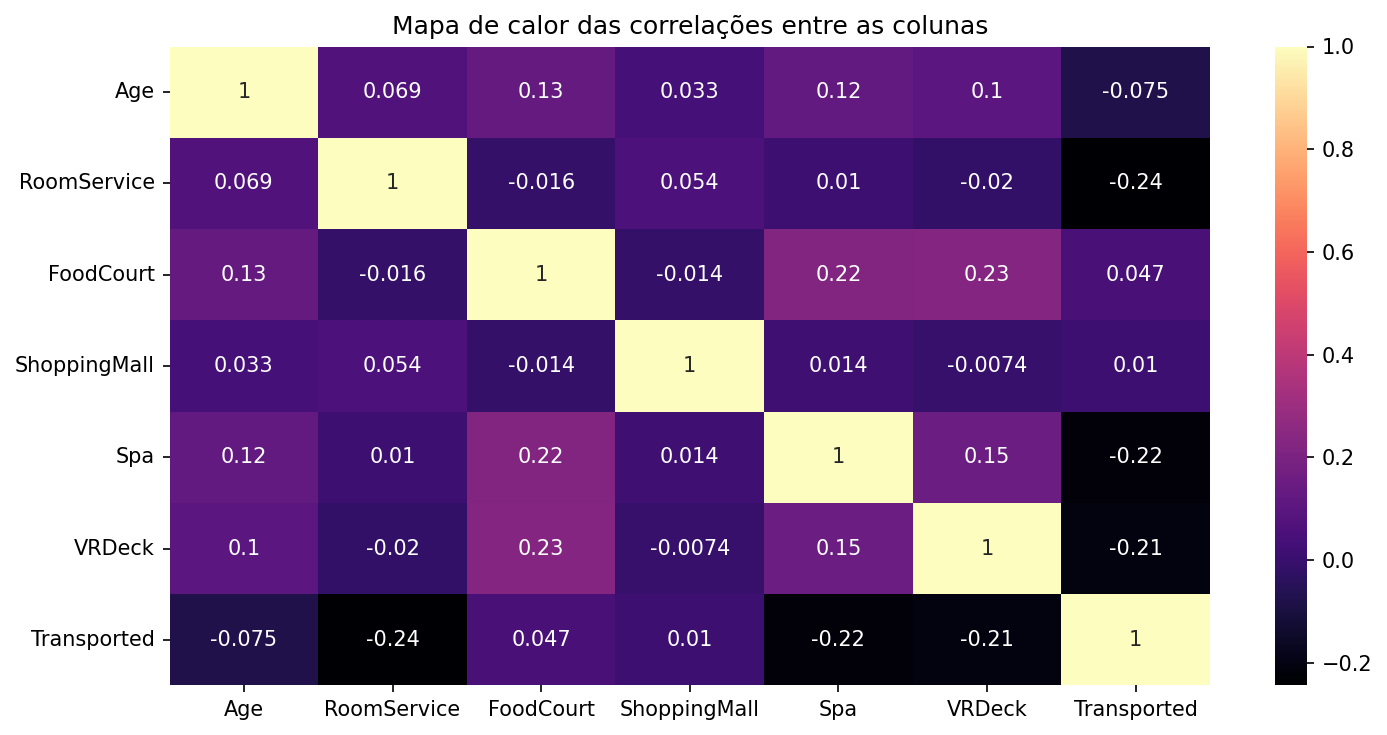

In [175]:
plt.figure(figsize = (10,5), dpi = 150)
sns.heatmap(data = visu_df.corr(), 
            annot = True, 
            cmap = 'magma')
plt.title('Mapa de calor das correlações entre as colunas')
plt.tight_layout()
plt.show()

Não há correlações fortes entre as colunas, porém é preciso notar que as colunas **"VRDeck"**, **"Spa"** e **"RoomService"** apresentam uma fraca correlação negativa com a coluna target **"Transported"**.

##### Gráficos de barras:

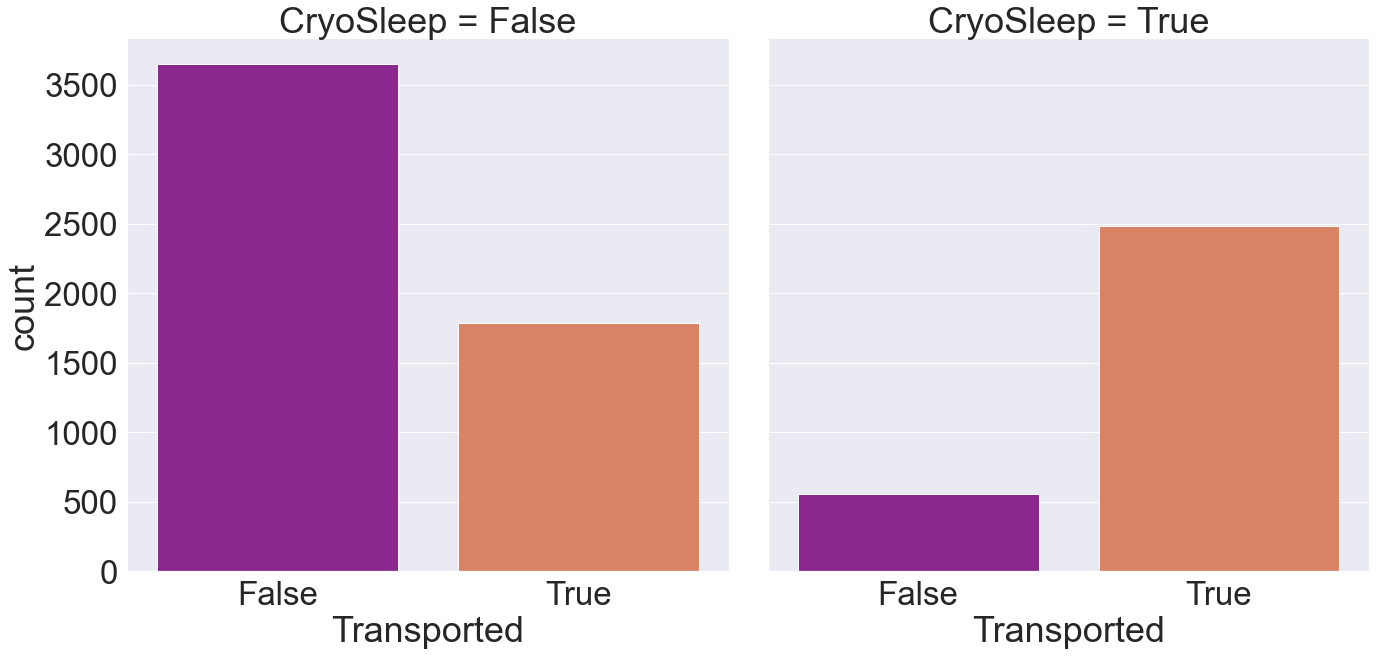

In [278]:
sns.catplot(data = train_df,
            col = 'CryoSleep',
            x = 'Transported',
            palette = 'plasma',
            kind = 'count',
            aspect = 1,
            height = 10)
plt.tight_layout()
plt.show()

Há uma relação relevante entre **"CryoSleep"** e **"Transported"**, pois é evidente que dado True em **"CryoSleep"** há uma porcentagem muito maior de pessoas transportadas, enquanto em False há uma quantidade maior de pessoas não-transportadas.

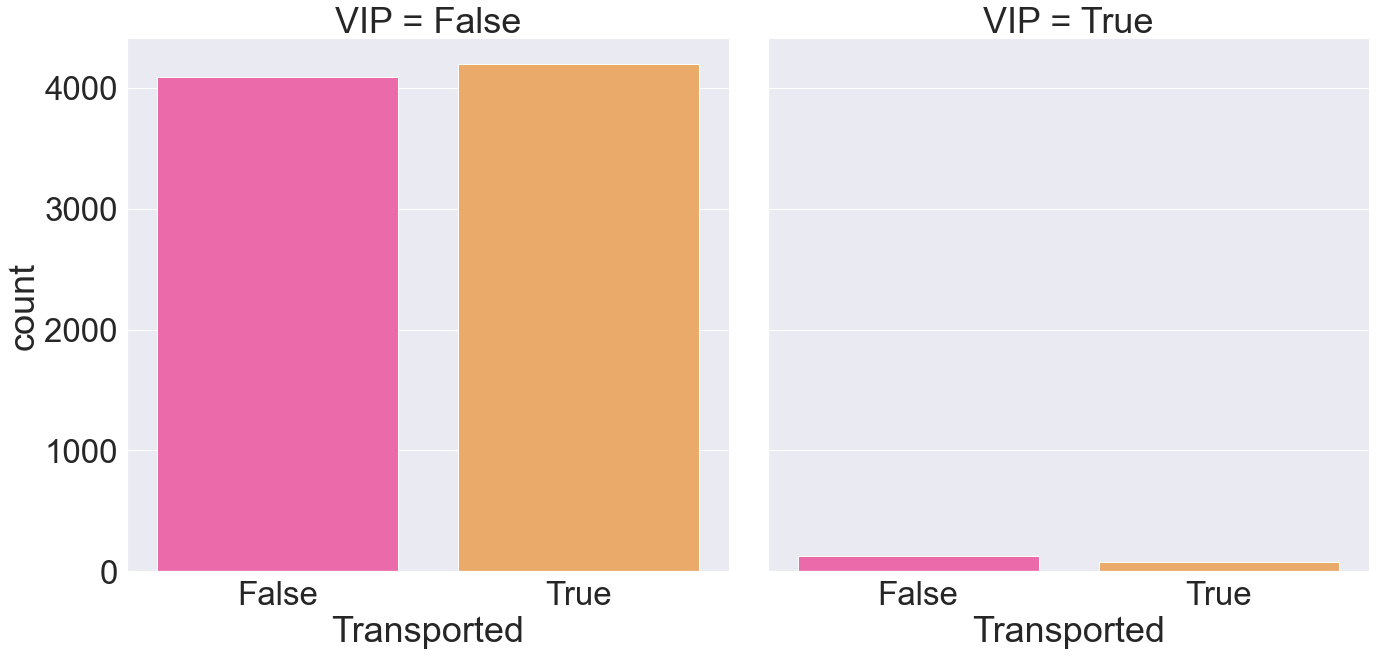

In [279]:
sns.catplot(data = train_df,
            col = 'VIP',
            x = 'Transported',
            palette = 'spring',
            kind = 'count',
            aspect = 1,
            height = 10)
plt.tight_layout()
plt.show()

A relação entre VIP e Transported é irrelevante, pois é visível que a proporção de Trues e Falses é semelhante, havendo uma quantidade próxima de transportados e não-transportados entre VIPs e não VIPs. A maioria absoluta não é VIP.

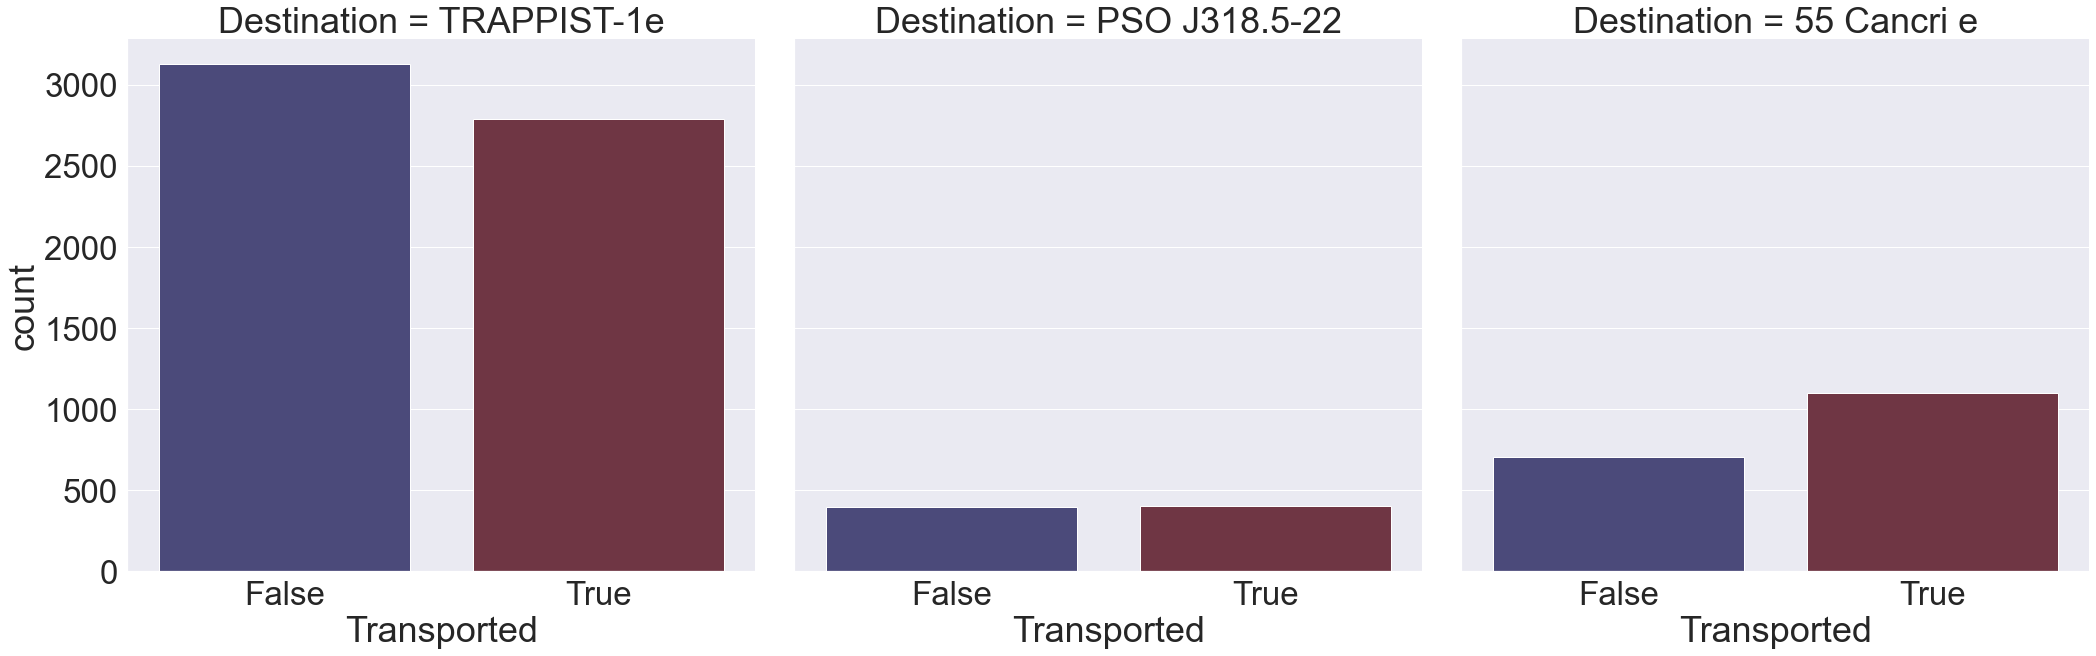

In [276]:
sns.catplot(data = train_df,
              col = 'Destination',
              x = 'Transported',
              palette = 'icefire',
              kind = 'count',
              aspect = 1,
              height = 10)
plt.tight_layout()
plt.show()

O destino dos tripulantes apresenta uma pequena correlação a feature target, visto que pessoas indo a TRAPPIST-1e tendem a ser menos transportadas, já pessoas com destino para 55 Cancri e apresentam uma maior quantidade de transportados, enquanto pessoas viajando para PSO J318.5-22 estão divididas igualmente entre transportados e não-transportados. A maioria das pessoas está viajando para TRAPPIST-1e.

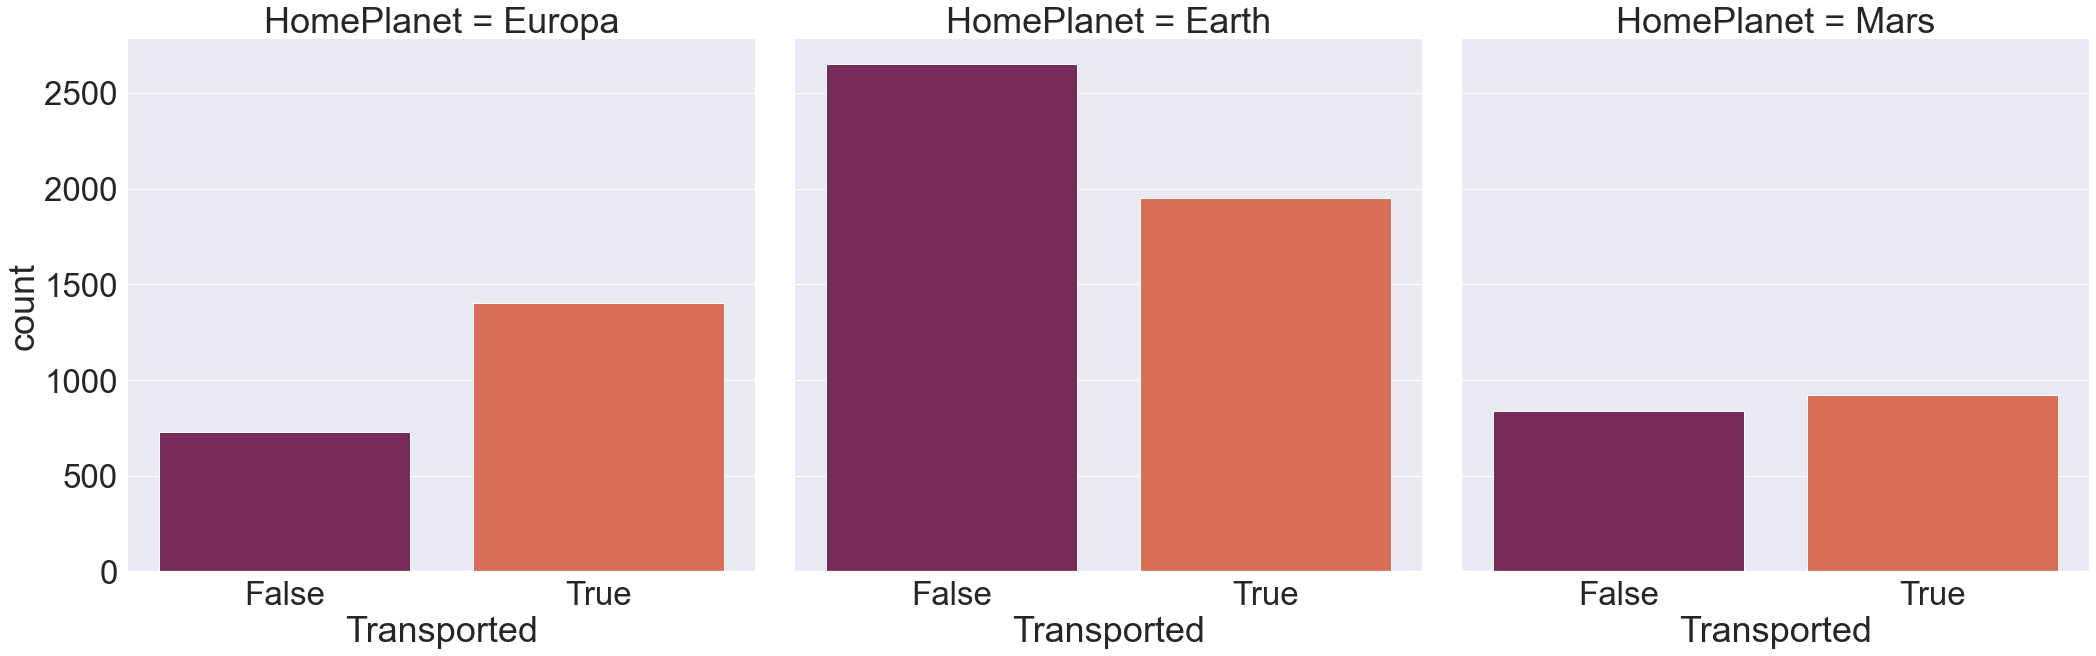

In [277]:
sns.catplot(data = train_df,
            col = 'HomePlanet',
            x = 'Transported',
            palette = 'rocket',
            kind = 'count',
            aspect = 1,
            height = 10)
plt.tight_layout()
plt.show()

As pessoas na Terra são percentualmente menos transportadas, em Marte a diferença entre transportados e não-transportados é irrelevante e as pessoas de Europa tem mais propensão a serem transportadas. A grande maioria das pessoas viajando é da Terra.

#### Identificando outliers:

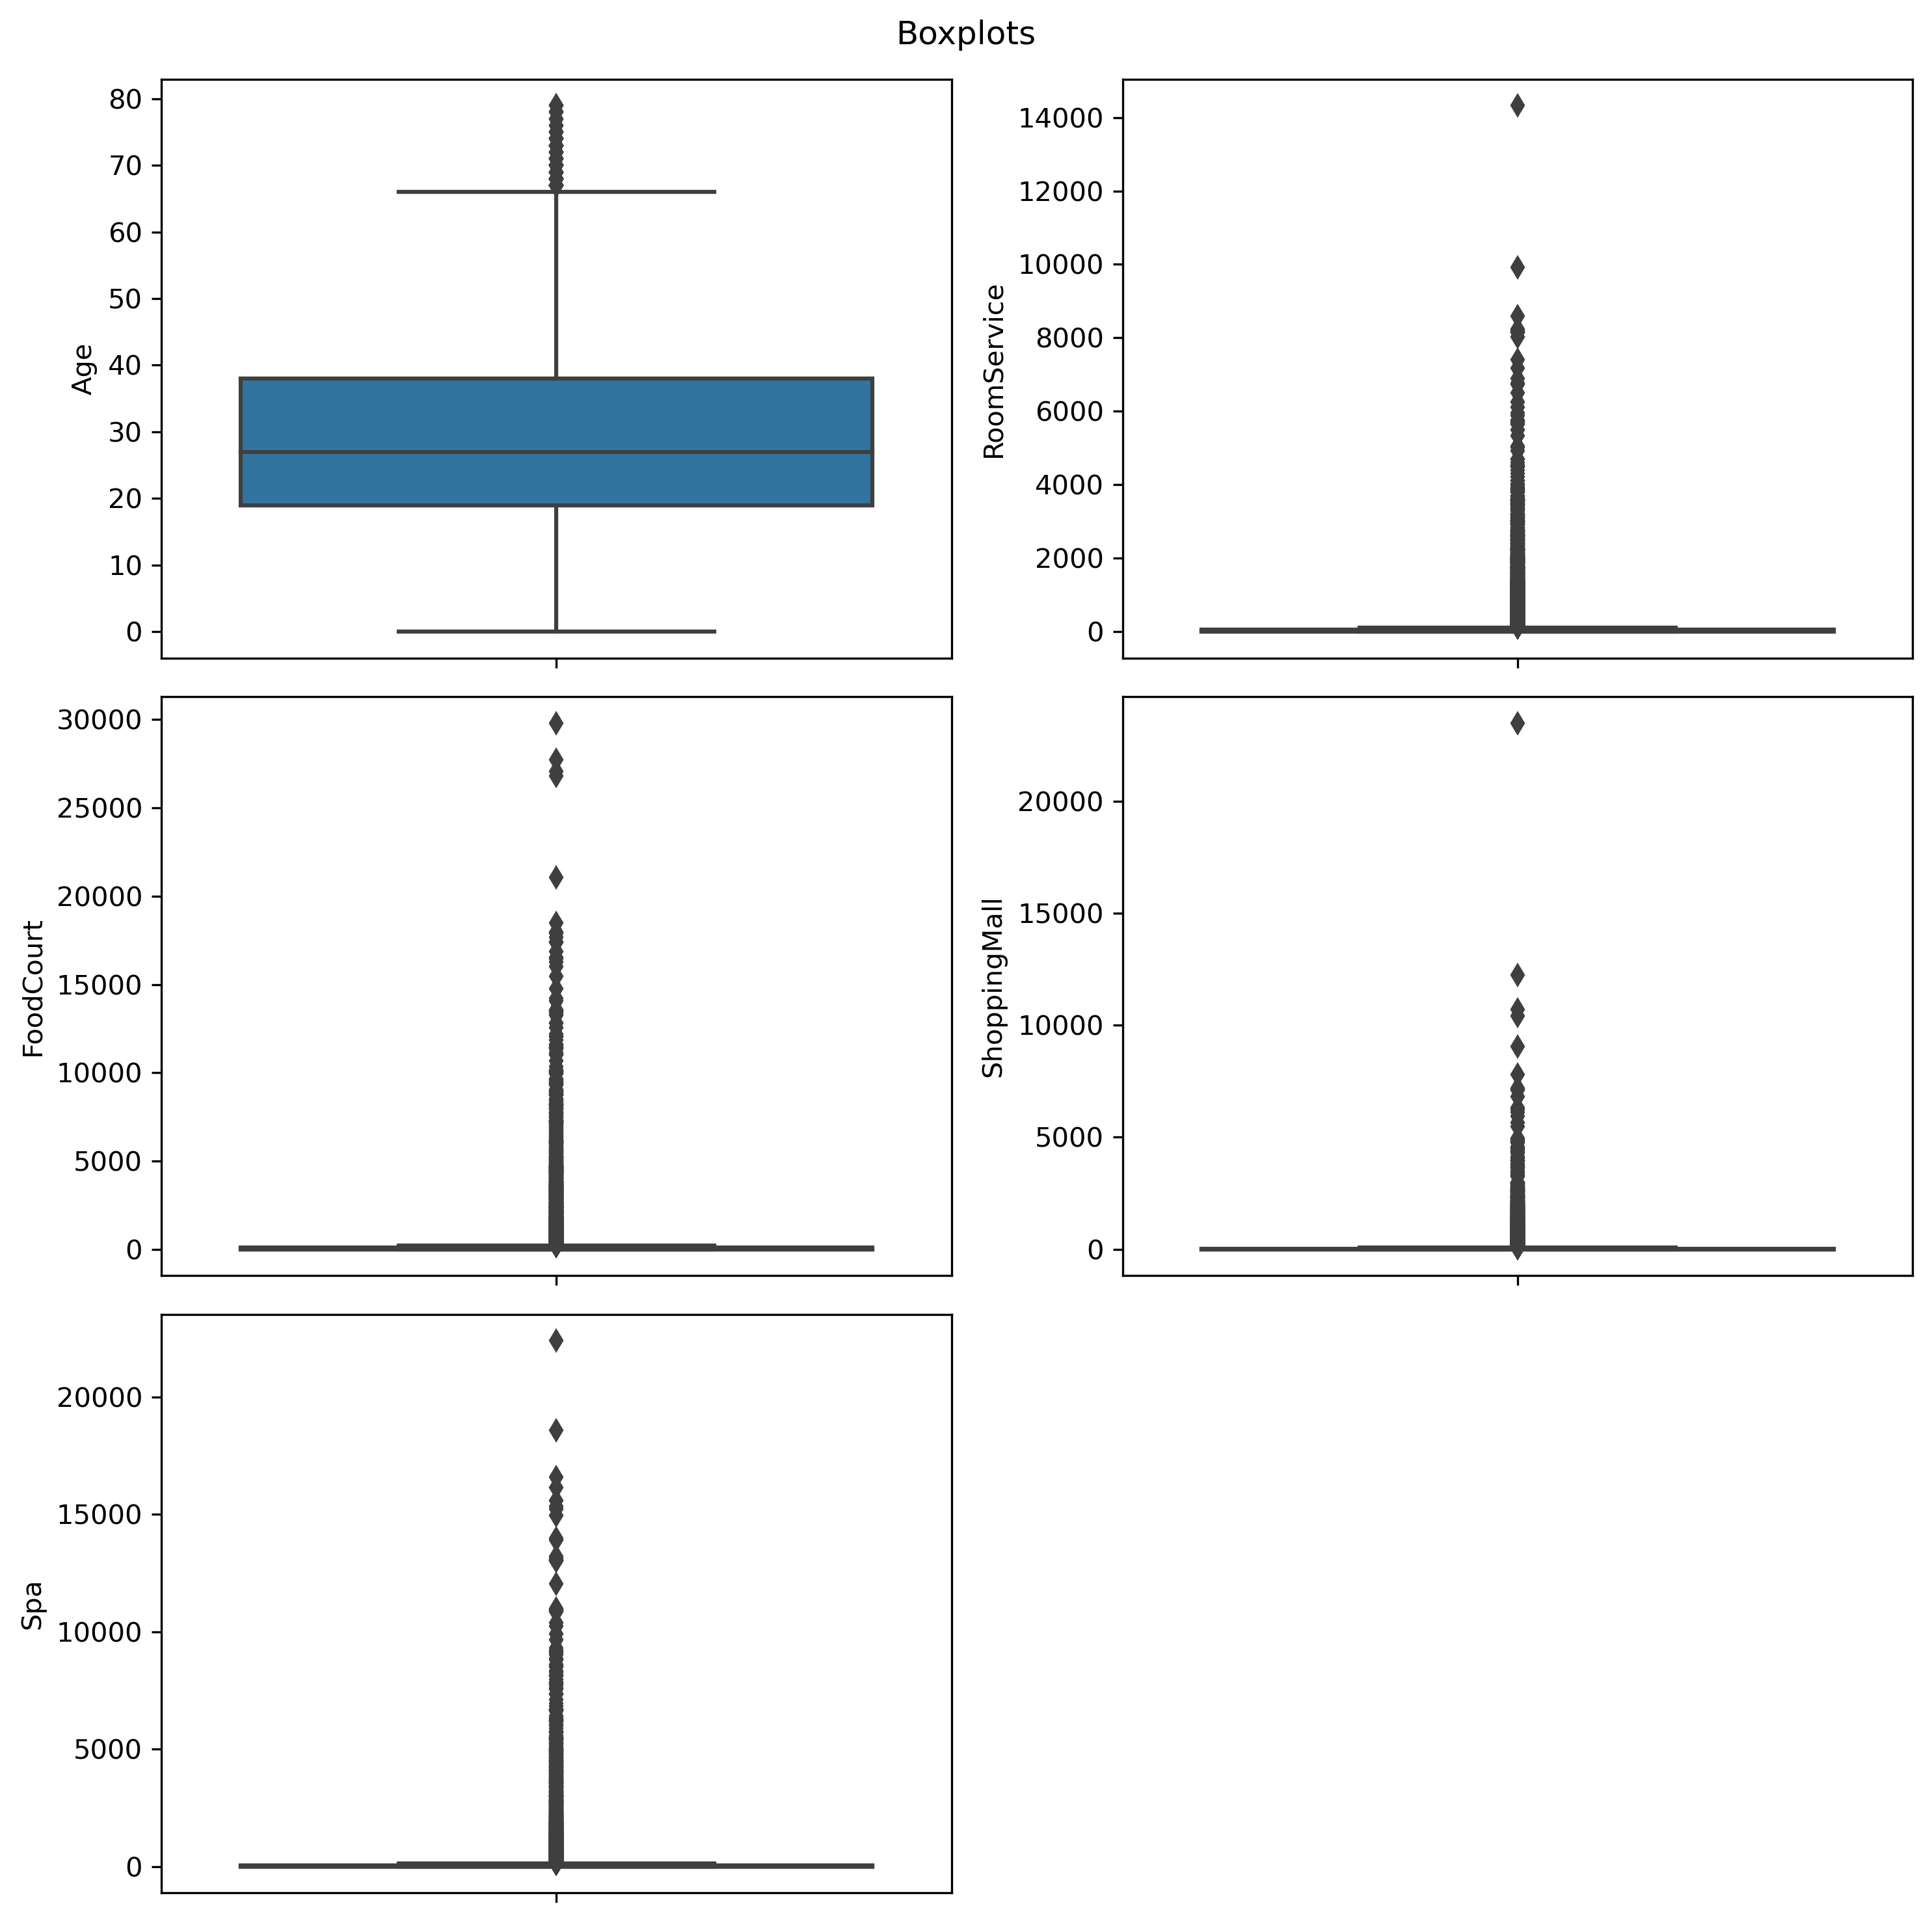

In [180]:
plt.figure(figsize = (10,10), dpi = 300)
plt.suptitle('Boxplots')
for index, col in zip([1,2,3,4,5], numeric_cols):
    plt.subplot(3,2,index)
    sns.boxplot(data = train_df, 
                y = col)
plt.tight_layout()
plt.show()

É possível concluir que os outliers são de fato um problema nesse dataset, pois são presentes em grandes quantidades em diversas colunas.

## Parte 3 - Tratamento dos dados:

### Feature Engineering:

####  Completando os valores faltando:

##### Colunas numéricas:

In [181]:
train_df[numeric_cols].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [182]:
train_df[numeric_cols].isna().sum() # Dados faltando

Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

Para completar as colunas, dividerei as colunas numéricas, imputando os dados faltando de **"Age"** a parte, pois as distribuições dos outros dados são semelhantes e totalmente diferentes de **"Age"**

###### Age:

In [94]:
def impute_age(df): # Função que imputa os números na coluna "Age"
    impute = df['Age'].dropna().sample(df['Age'].isnull().sum()).to_list()
    indexes = df[df['Age'].isnull()].index.to_list()
    df.loc[indexes,'Age'] = impute
    return df

In [95]:
impute_age(train_df).head(3) # Completando o dataset

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [96]:
train_df['Age'].isnull().sum() # Dados faltando

0

Text(0, 0.5, 'Densidade')

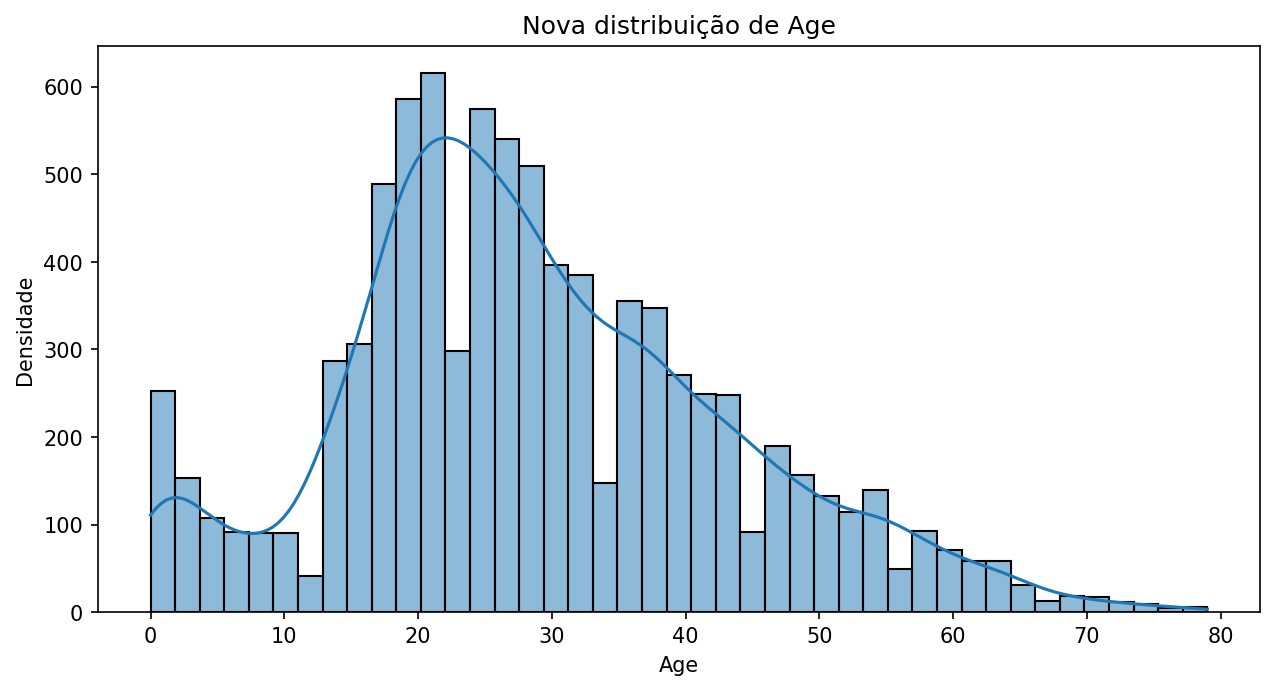

In [186]:
plt.figure(figsize = (10,5), dpi = 150)
sns.histplot(train_df['Age'], 
             kde=True)
plt.title('Nova distribuição de Age')
plt.ylabel('Densidade')

Como é possível perceber, após a imputação de dados, a distribuição dos dados em **"Age"** continua igual, graças ao método de Random Sampling aplicado.

###### Medidas de Luxo:

In [97]:
imputer = SimpleImputer(strategy = 'most_frequent') # Preparando o imputer
train_df[numeric_cols[1:]] = imputer.fit_transform(train_df[numeric_cols[1:]]) # Completando as colunas

In [98]:
train_df[numeric_cols[1:]].isnull().sum() # Dados faltando

RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

Todas os dados faltando foram completados por 0, que é o número mais frequente nas 5 colunas, consistindo de basicamente 3/4 dos dados, por isso sua adição não distorceu a distribuição, que já era concentrada no 0.

##### Colunas categóricas:

In [190]:
train_df[categorical_cols].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


* É possível presumir o valor faltando da coluna **"CryoSleep"**, pois quando os passegeiros estão em sono criogênco eles não consomem.
* **"Name"** e **"Cabin"** não vão entrar no modelo, no máximo serão extraídas features a partir dessas colunas.
* As outras colunas serão imputados com o dado de maior frequência.

In [191]:
train_df[categorical_cols].isna().sum() # Dados faltando

PassengerId      0
HomePlanet     201
CryoSleep      217
Cabin          199
Destination    182
VIP            203
Name           200
dtype: int64

In [99]:
colunas = ['VIP','Destination','HomePlanet'] # Completando essas colunas
train_df[colunas] = imputer.fit_transform(train_df[colunas])

In [100]:
train_df[categorical_cols].isna().sum() # Dados faltando

PassengerId      0
HomePlanet       0
CryoSleep      217
Cabin          199
Destination      0
VIP              0
Name           200
dtype: int64

CryoSleep vai ser imputada posteriormente, pois será criada uma feature nova que captura todos os gastos com luxos, facilitando o processo.

#### Criando novas features:

##### Intuições: 
1. Durante a exploração de dados foi identificada uma grande disparidade entre os dados quanto ao consumo de luxos, ocorrendo uma clara separação em 2 grupos, os que consomem e os que não consomem. Havendo cerca de 3/4 que tem um gasto em luxos de 0, e um grupo de 1/4 que gasta com luxos, entre esses 1/4 há uma grande variação nos gastos.

2. É possível extrair os grupos de passegeiros a partir da coluna **"PassengerID"**.

3. A coluna **"Cabin"** entrega 2 informações interessantes, o deck no qual o passageiro está hospedado e o lado no qual a cabine está alocada.

##### Desenvolvendo a primeira intuição:

In [101]:
total_gasto = 0 # Somando todos os gastos em luxo
for index in range(1,6):
    total_gasto += train_df[numeric_cols[index]]

In [102]:
train_df['SomaLuxos'] = total_gasto # Colocando a agregação na base de dados

###### Análise:

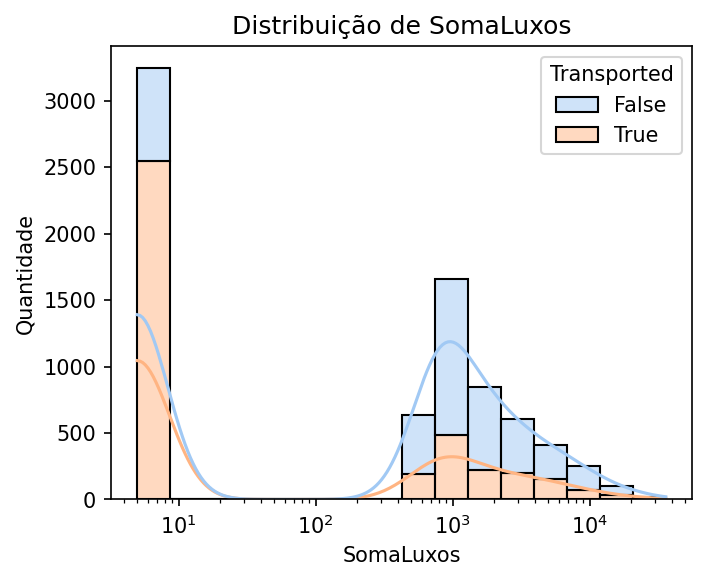

In [199]:
plt.figure(figsize = (5,4), dpi = 150)
sns.histplot(data = train_df,
             x = 'SomaLuxos',
             log_scale = True,
             hue = 'Transported',
             multiple = 'stack',
             kde = True,
             palette='pastel')
plt.ylabel('Quantidade')
plt.title('Distribuição de SomaLuxos')
plt.show()

Nas distribuições separadas era possível identificar uma discrepância grande nos gastos, porém agora com seus valores agregados, é possível eliminar o fator das predileções particulares de cada tripulante por determinados serviços, conseguindo uma separação perfeita entre pessoas que gastam em luxos e pessoas que não gastam. A maior descoberta dessa agregação é o fato de que pessoas com gastos em luxos são menos transportadas do que pessoas que não gastam, sendo a diferença muito grande para ser uma mera coincidência.

In [104]:
def separar_grupos(number): # Essa é a função para formar a nova feature
    if number == 0:
        return 0 
    else:
        return 1

In [105]:
train_df['ConsomeLuxo'] = train_df['SomaLuxos'].apply(separar_grupos) # Criando a feature

Como havia uma clara separação entre quem consome e quem não consome luxos, acredito que seja mais inteligente formar uma feature categórica que determina o consumo de luxo, para identificar a relação entre o consumo de luxo e ser transportado.

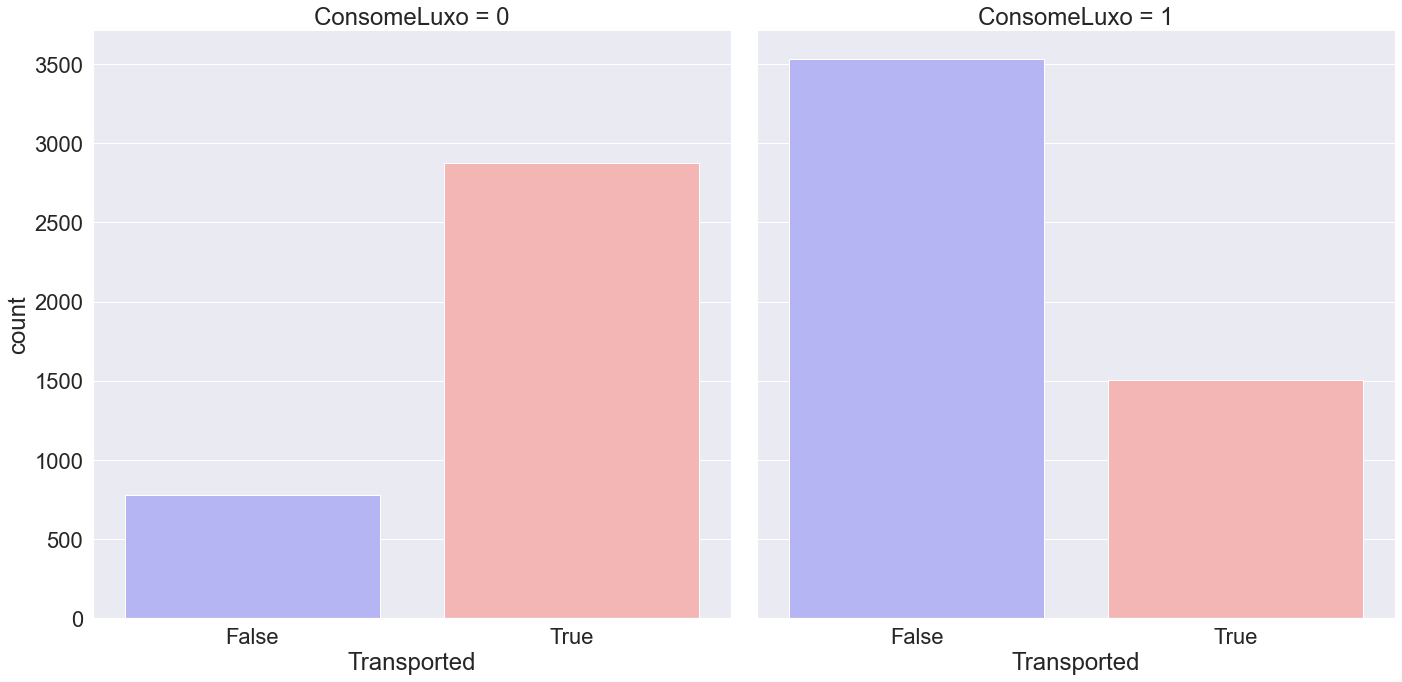

In [113]:
sns.catplot(data = train_df,
            col = 'ConsomeLuxo',
            x = 'Transported',
            palette = 'bwr',
            kind = 'count',
            aspect = 1,
            height = 10)
plt.tight_layout()
plt.show()

É visível a relação entre as 2 variavéis, havendo uma quantidade muito grande de transportados entre quem não consome luxos, e dentre quem consome, uma minoria foi transportada.

###### CryoSleep:
Agora que existe uma feature que define o consumo de luxos, é possível aumentar as probabilidades de completar os dados com exatidão.

In [114]:
def definir_cryo(n): # Função que define se uma pessoa está em sono criogênico ou não
    if n >= 1:
        return False 
    else:
        return True

In [115]:
def impute_cryo(df): # Imputando os dados faltando em "CryoSleep"
    serie = df.loc[df['CryoSleep'].isna() == True,'ConsomeLuxo'].apply(definir_cryo)
    impute = serie.to_list()
    indexes = df[df['CryoSleep'].isnull()].index.to_list()
    df.loc[indexes,'CryoSleep'] = impute
    return df 

In [116]:
impute_cryo(train_df).head(2) # imputando os dados

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,SomaLuxos,ConsomeLuxo
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,1


In [222]:
train_df['CryoSleep'].isnull().sum()

0

Agora todas as features originais relevantes foram imputadas.

##### Desenvolvendo a segunda intuição:

In [117]:
train_df['Grupos'] = train_df['PassengerId'].str[0:4] # Cortando os grupos dos ids

In [118]:
n_groups = pd.DataFrame([train_df['Grupos'].value_counts(ascending=False)]) #Criando a feature 
n_df = n_groups.T
n_df.reset_index(inplace = True)
n_df.rename(columns = {'Grupos':'N_grupo','index':'Grupos'}, inplace = True)

In [119]:
train_df = train_df.merge(n_df, how = 'left', on = "Grupos") # juntando a nova feature no dataframe

Através dos dados dos ids dos passageiros foi possível deduzir o tamanho do grupo ao qual fazem parte, gerando a feature **"N_grupo"** que representa a quantidade de pessoas no grupo fora o indivíduo.

###### Análise:

In [214]:
ordem = train_df[['N_grupo',
                  'Transported']].groupby('N_grupo').mean().sort_values('Transported',
                                                                          ascending = False).index.to_list()
order = [str(n) for n in ordem] # Ordem decrescente 

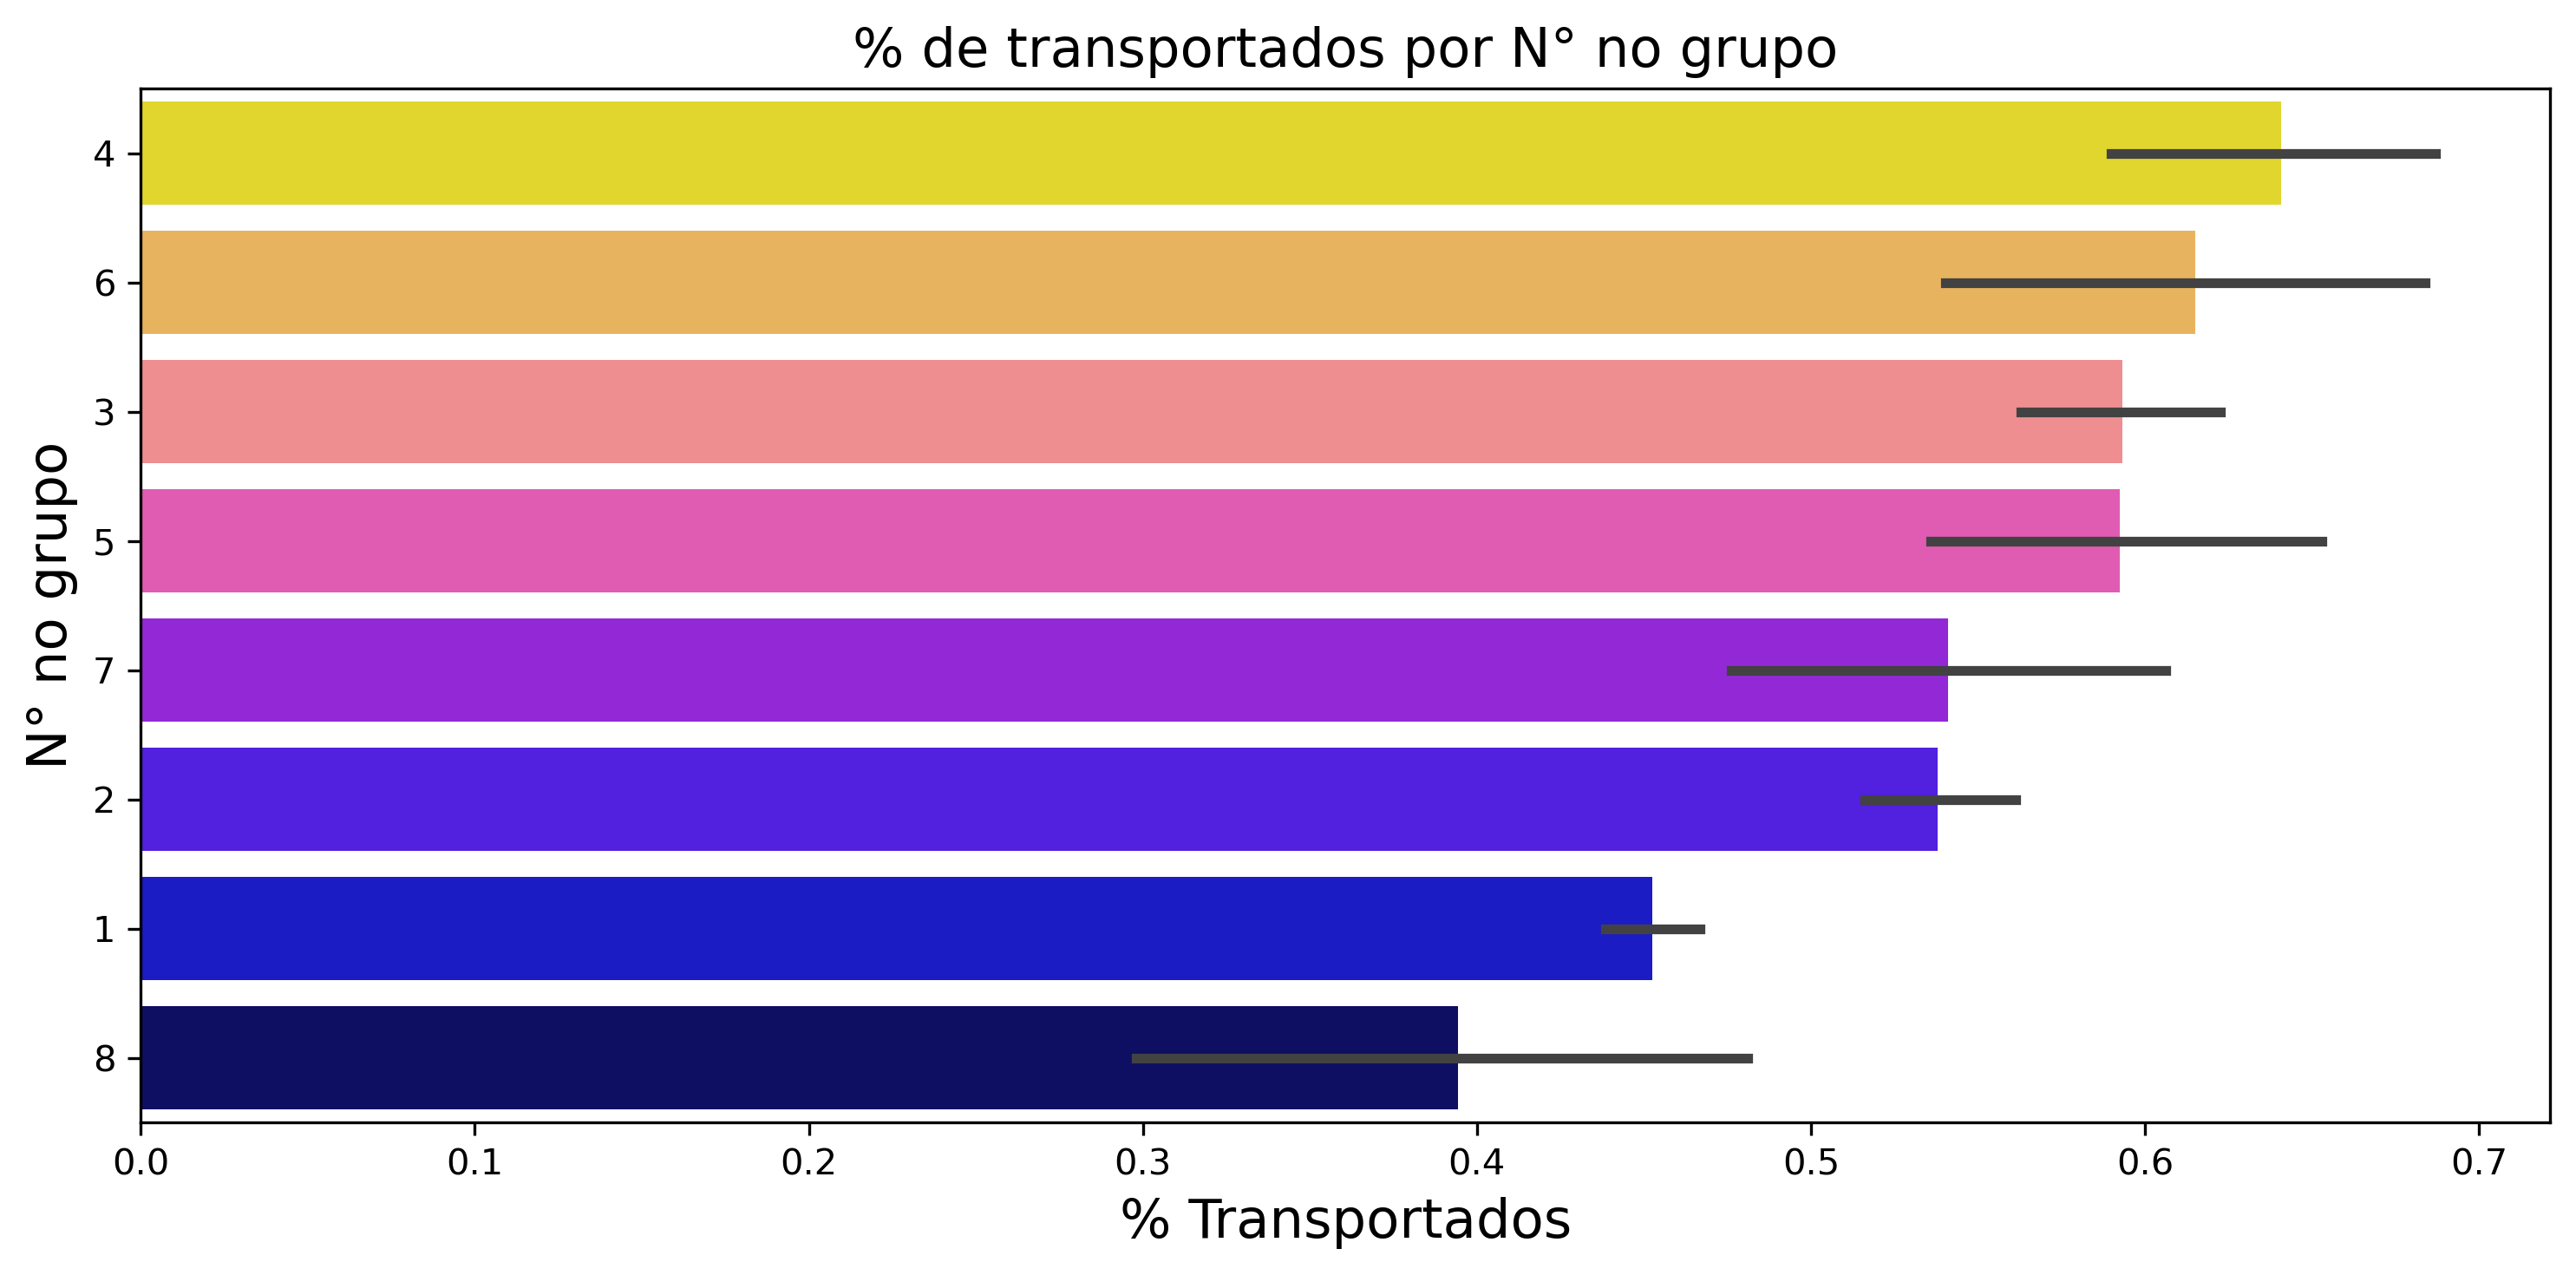

In [216]:
plt.figure(figsize = (10,5), dpi = 300)
sns.barplot(data = train_df,
            x = 'Transported',
            y = train_df['N_grupo'].astype(str),
            palette = 'gnuplot2_r',
            order = order)
plt.title('% de transportados por N° no grupo', fontsize = 15)
plt.ylabel('N° no grupo', fontsize = 15)
plt.xlabel('% Transportados', fontsize = 15)
plt.tight_layout()
plt.show()

É possível presumir que, dado que o dataset é equilibrado na porcentagem de transportados, o número de pessoas em cada grupo não parece ser um fator levado em conta no momento do transporte. Pois, todos os valores apresentam uma média próxima de 50 % de transportados, ainda mais levando em conta que a maioria dos intervalos de confiança se encontra.

##### Desenvolvendo a terceira intuição:

###### Deck:

In [120]:
train_df['Deck'] = train_df.Cabin.str[0] # Capturando a feature 
train_df['Deck']

0       B
1       F
2       A
3       A
4       F
       ..
8688    A
8689    G
8690    G
8691    E
8692    E
Name: Deck, Length: 8693, dtype: object

In [227]:
deck_df = train_df[['Deck','Transported']].groupby('Deck').mean().sort_values('Transported', ascending = False)

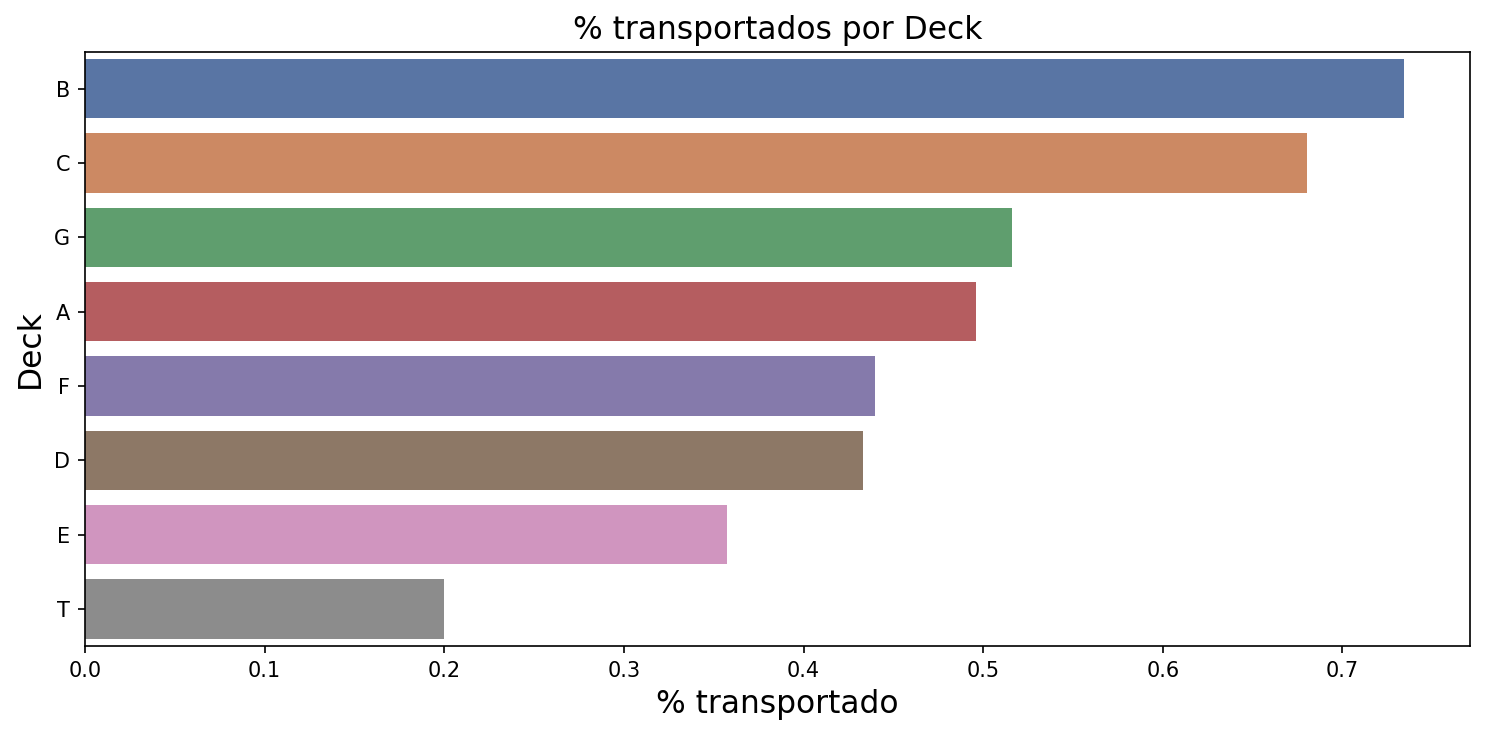

In [219]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = deck_df,
            y = deck_df.index, 
            x = 'Transported',
            palette = 'deep')
plt.title('% transportados por Deck', fontsize = 15)
plt.ylabel('Deck', fontsize = 15)
plt.xlabel('% transportado', fontsize = 15)
plt.tight_layout()
plt.show()

A nova feature **"Deck"**, acrescenta informações interessantes ao dataframe, pois há uma grande variação na porcentagem de transportados entre os decks, como no deck "T" em que houve uma porcentagem muito pequena de transportados, ao contrário do deck "B" em que a maioria foi transportado.

In [121]:
train_df['Deck'] = imputer.fit_transform(train_df[['Deck']])

In [122]:
train_df['Deck'].isna().sum()

0

###### Side:

In [123]:
train_df['Side'] = train_df.Cabin.str[-1] # Capturando a feature
train_df['Side']

0       P
1       S
2       S
3       S
4       S
       ..
8688    P
8689    S
8690    S
8691    S
8692    S
Name: Side, Length: 8693, dtype: object

In [223]:
side_df = train_df[['Side','Transported']].groupby('Side').mean().sort_values('Transported', ascending = False)

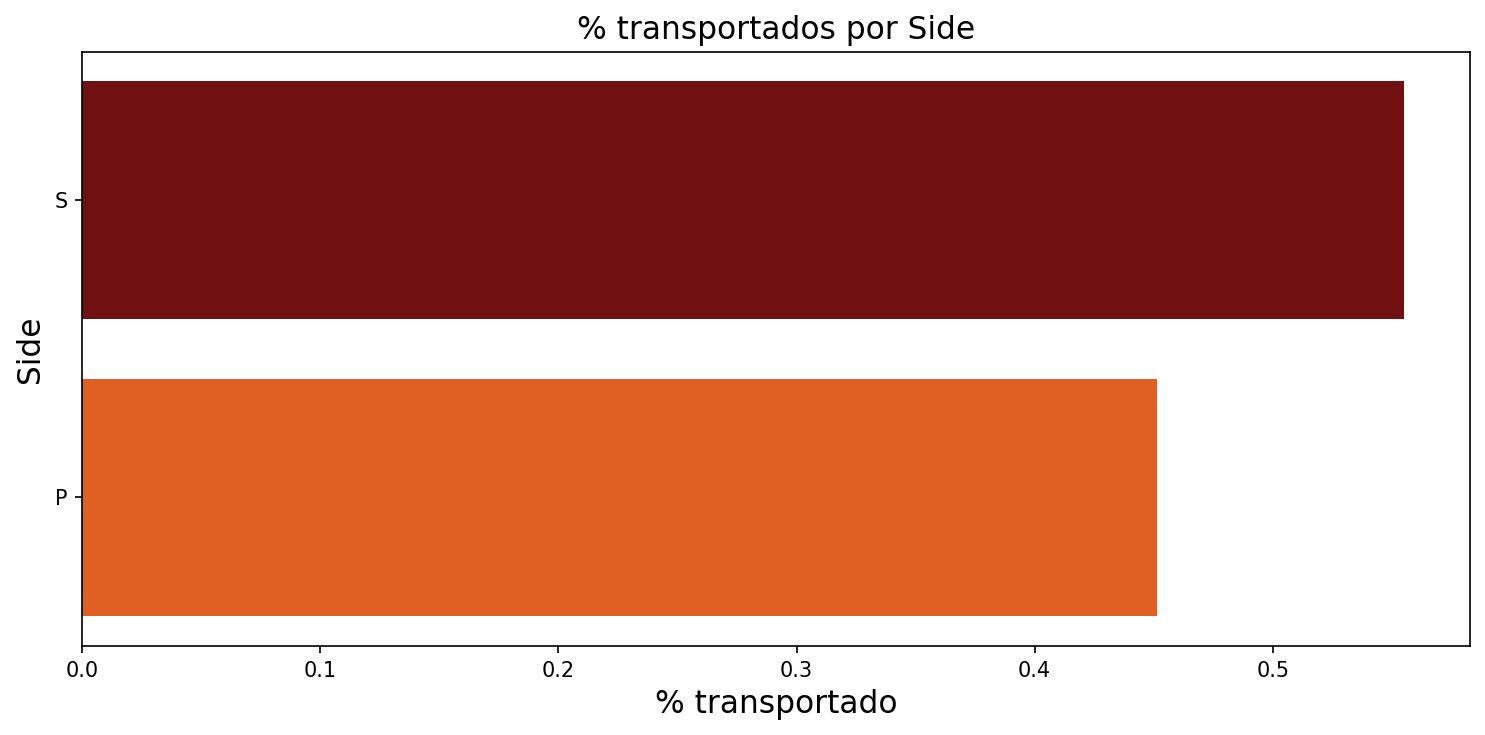

In [224]:
plt.figure(figsize = (10,5), dpi = 150)
sns.barplot(data = side_df,
            y = side_df.index, 
            x = 'Transported',
            palette = 'gist_heat')
plt.title('% transportados por Side', fontsize = 15)
plt.ylabel('Side', fontsize = 15)
plt.xlabel('% transportado', fontsize = 15)
plt.tight_layout()
plt.show()

A feature **"Side"** aparentemente denota uma porcentagem maior de transportados do lado "S", porém não chega a ser uma diferença grande o bastante para ser confirmada como algo além de aleatoriedade.

In [124]:
def impute_side(df): # Função que imputa os números na coluna "Side"
    impute = df['Side'].dropna().sample(df['Side'].isnull().sum()).to_list()
    indexes = df[df['Side'].isnull()].index.to_list()
    df.loc[indexes,'Side'] = impute
    return df

In [125]:
impute_side(train_df) # Imputando dados em Side
train_df['Side'].isna().sum()

0

#### Nova separação das features:

In [126]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination','VIP',
                    'Deck', 'Side', 'N_grupo', 'ConsomeLuxo']

In [127]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'SomaLuxos']

Nova separação das features, excluindo as features **"Grupos"**, pois já é representada pela feature **"N_grupos"**, **"Name"**,**"PassengerId"** e **"Cabin"** foram excluídas também pois não agregam informações ao modelo.

#### Escalando os dados:

In [229]:
train_df[numeric_cols].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SomaLuxos
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,736.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1091.0


In [129]:
scaler = RobustScaler() # Escalonando os dados
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

In [236]:
train_df[numeric_cols].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SomaLuxos
0,0.631579,0.000000,0.000000,0.000000,0.000000,0.000,-0.496877
1,-0.157895,2.658537,0.147541,1.136364,10.358491,1.100,0.013879
2,1.631579,1.048780,58.622951,0.000000,126.698113,1.225,6.708536
3,0.315789,0.000000,21.032787,16.863636,62.811321,4.825,3.095073
4,-0.578947,7.390244,1.147541,6.863636,10.660377,0.050,0.260236


Agora as features contínuas estão devidamente escaladas. O RobustScaler foi utilizado pois há uma quantidade muito grande de outliers na base de dados.

#### Codificação dos dados categóricos:

In [232]:
train_df[categorical_cols].head()

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,N_grupo,ConsomeLuxo
0,Europa,False,TRAPPIST-1e,False,B,P,1,0
1,Earth,False,TRAPPIST-1e,False,F,S,1,1
2,Europa,False,TRAPPIST-1e,True,A,S,2,1
3,Europa,False,TRAPPIST-1e,False,A,S,2,1
4,Earth,False,TRAPPIST-1e,False,F,S,1,1


##### Colunas com muitas variáveis:

In [233]:
train_df[['N_grupo','Deck']].head()

,N_grupo,Deck
0,1,B
1,1,F
2,2,A
3,2,A
4,1,F


In [130]:
deck_df = train_df[['Deck','Transported']].groupby('Deck').mean().sort_values('Transported', ascending = True)
display(deck_df) # DF com o deck e a % correspondente de ser transportado

,Transported
Deck,
T,0.200000
E,0.357306
D,0.433054
F,0.444036
A,0.496094
G,0.516217
C,0.680054
B,0.734275


In [131]:
labels_deck = deck_df.index.to_list()
deck_mapper = {d:n for d,n in zip(labels_deck,range(0,len(labels_deck)))} # Mapeador do deck
print(deck_mapper)

{'T': 0, 'E': 1, 'D': 2, 'F': 3, 'A': 4, 'G': 5, 'C': 6, 'B': 7}


In [132]:
n_df = train_df[['N_grupo','Transported']].groupby('N_grupo').mean().sort_values('Transported', ascending = False)
display(n_df) # DF com o n° no grupo e a % correspondente de ser transportado

,Transported
N_grupo,
4,0.640777
6,0.614943
3,0.593137
5,0.592453
7,0.541126
2,0.538050
1,0.452445
8,0.394231


In [133]:
labels_n = n_df.index.to_list()
n_mapper = {d:n for d,n in zip(labels_n,range(0,len(labels_n)))} # Mapeador do N_grupo
print(n_mapper)

{4: 0, 6: 1, 3: 2, 5: 3, 7: 4, 2: 5, 1: 6, 8: 7}


In [134]:
train_df['Deck'] = train_df['Deck'].map(deck_mapper) # Transformando os dados
train_df['N_grupo'] = train_df['N_grupo'].map(n_mapper)

In [135]:
train_df[['Deck','N_grupo']].head()

,Deck,N_grupo
0,7,6
1,3,6
2,4,5
3,4,5
4,3,6


##### Colunas binárias:

In [240]:
train_df[['CryoSleep','VIP','ConsomeLuxo','Side']].head()

,CryoSleep,VIP,ConsomeLuxo,Side
0,False,False,0,P
1,False,False,1,S
2,False,True,1,S
3,False,False,1,S
4,False,False,1,S


In [136]:
bool_mapper = {False:0, True:1} # Mapeadores para transformar os dados
side_mapper = {'P':0, 'S':1}

In [137]:
train_df['CryoSleep'] = train_df['CryoSleep'].map(bool_mapper) # Transformando as features
train_df['VIP'] = train_df['VIP'].map(bool_mapper)
train_df['Side'] = train_df['Side'].map(side_mapper)

In [138]:
train_df[['CryoSleep','VIP','ConsomeLuxo','Side']].head()

,CryoSleep,VIP,ConsomeLuxo,Side
0,0,0,0,0
1,0,0,1,1
2,0,1,1,1
3,0,0,1,1
4,0,0,1,1


##### One hot encoding:

In [244]:
train_df[['HomePlanet','Destination']].head()

,HomePlanet,Destination
0,Europa,TRAPPIST-1e
1,Earth,TRAPPIST-1e
2,Europa,TRAPPIST-1e
3,Europa,TRAPPIST-1e
4,Earth,TRAPPIST-1e


In [139]:
encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore') # Treinando o modelo 
encoder.fit(train_df[['HomePlanet','Destination']])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [140]:
features_names = list(encoder.get_feature_names_out()) # Nomes das novas features
train_df[features_names] = encoder.transform(train_df[['HomePlanet','Destination']]) # Colocando no modelo

Agora todas as features estão prontas para serem selecionadas para o modelo.

### Feature Selection:

In [141]:
y = train_df['Transported'] # Retirando o target do dataframe
train_df = train_df.drop('Transported',axis = 1)

In [142]:
# Retirando as colunas que não servem para o modelo
features_df = train_df.drop(['PassengerId','HomePlanet','Cabin','Destination','Grupos','Name'], axis = 1)

In [143]:
n_cols = len(features_df.columns)
print(f'O número de features no modelo é de {n_cols}')

O número de features no modelo é de 19


Há 19 features no modelo, dentre elas selecionaremos as que entrarão no modelo.

#### Seleção por ganho de informação:

In [144]:
inf_array = mutual_info_classif(features_df,y)
gain_df = pd.DataFrame(inf_array, index = features_df.columns, columns = ['Gain'])
gain_df.sort_values('Gain', ascending = False)

,Gain
SomaLuxos,0.134608
ConsomeLuxo,0.120018
CryoSleep,0.113172
Spa,0.072698
RoomService,0.070284
VRDeck,0.056906
FoodCourt,0.052282
ShoppingMall,0.048259
Deck,0.026254
HomePlanet_Europa,0.022435


É notável que as features com mais ganho de informação são as features relacionadas ao consumo de luxos e **"CryoSleep"**, seguido por **"Deck"** e **"HomePlanet"**, a partir disso as features apresentam pouco ou nenhum ganho informacional.

#### Seleção por chi2:

In [251]:
chi2_df = features_df[['CryoSleep','VIP','ConsomeLuxo','N_grupo',
             'Deck','Side','HomePlanet_Earth','HomePlanet_Europa',
             'HomePlanet_Mars','Destination_55 Cancri e',
             'Destination_PSO J318.5-22','Destination_TRAPPIST-1e']]

In [252]:
f_selector = SelectKBest(score_func = chi2, k = 10)
f_selector.fit(chi2_df,y)
f_array = f_selector.scores_
f_df = pd.DataFrame(f_array, index = chi2_df.columns, columns = ['Score'] )
f_df.sort_values('Score',ascending = False)

,Score
CryoSleep,1213.330732
ConsomeLuxo,844.741285
Deck,250.506641
HomePlanet_Europa,205.386948
HomePlanet_Earth,110.899064
N_grupo,87.678076
Destination_55 Cancri e,81.479029
Side,45.711000
Destination_TRAPPIST-1e,24.083879
VIP,11.792812


Na seleção por Chi2 as features com mais importância são as mesmas de antes, porém com uma diferença na ordem.

#### Escolhendo as features:

In [162]:
features_df.drop(["Spa", "RoomService", "VRDeck", 
                  "ShoppingMall","FoodCourt"], axis = 1, inplace = True)

Essas features estão sendo retiradas do dataset, pois elas compõem através de uma soma a feature **"SomaLuxos"**. As features restantes serão utilizadas na modelagem.

In [163]:
features_df.head()

,CryoSleep,Age,VIP,SomaLuxos,ConsomeLuxo,N_grupo,Deck,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,0.631579,0,-0.496877,0,6,7,0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,-0.157895,0,0.013879,1,6,3,1,1.0,0.0,0.0,0.0,0.0,1.0
2,0,1.631579,1,6.708536,1,5,4,1,0.0,1.0,0.0,0.0,0.0,1.0
3,0,0.315789,0,3.095073,1,5,4,1,0.0,1.0,0.0,0.0,0.0,1.0
4,0,-0.578947,0,0.260236,1,6,3,1,1.0,0.0,0.0,0.0,0.0,1.0


In [164]:
features_model = len(features_df.columns)
print(f'Serão usadas {features_model} features nos modelos.')

Serão usadas 14 features nos modelos.


#### Salvando o trabalho:

In [165]:
features_df.to_csv('features_df.csv', index = False)
y.to_csv('y.csv', index = False)

## Parte 4 - Selecionando o modelo:

### Carregando o dataset:

In [166]:
train_df = pd.read_csv('features_df.csv')
y = pd.read_csv('y.csv')
display(train_df.head(), y.head())

,CryoSleep,Age,VIP,SomaLuxos,ConsomeLuxo,N_grupo,Deck,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,0.631579,0,-0.496877,0,6,7,0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,-0.157895,0,0.013879,1,6,3,1,1.0,0.0,0.0,0.0,0.0,1.0
2,0,1.631579,1,6.708536,1,5,4,1,0.0,1.0,0.0,0.0,0.0,1.0
3,0,0.315789,0,3.095073,1,5,4,1,0.0,1.0,0.0,0.0,0.0,1.0
4,0,-0.578947,0,0.260236,1,6,3,1,1.0,0.0,0.0,0.0,0.0,1.0


,Transported
0,False
1,True
2,False
3,False
4,True


In [167]:
y = np.where(y == False, 0 , 1) # Convertendo o target

In [168]:
X_train, X_val, y_train, y_val = train_test_split(train_df,y, random_state = 20) # Separando os dados em treino e validação

### Selecionando os modelos:

#### Modelo escolhido:

Será testado o modelo de  **XGBoost Classifier**.

#### Montando o modelo:

#### XGBClassifier:

In [115]:
xgb = XGBClassifier(random_state = 20, n_jobs = -1, verbosity = 0) # Modelo

In [118]:
xgb.fit(X_train, y_train.ravel()) # Treinando o modelo
xgb_predict = xgb.predict(X_val) # Previsão

C:\Users\Thomas\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Thomas\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [185]:
print('Classification report')
print(classification_report(xgb_predict, y_val))

Classification report
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1222
           1       0.67      0.78      0.72       952

    accuracy                           0.74      2174
   macro avg       0.74      0.74      0.74      2174
weighted avg       0.75      0.74      0.74      2174



O modelo em sua forma padrão, apresenta uma precisão de 74%, se tratando da precisão, ela se destaca na label 0 (Não-transportado) com 81%, já na label 1 (Transportado) apresenta 70% de precisão, um resultado mediano. Já quanto ao recall, na label 0 é de 70%, e na label 1 é de 78%, um resultado interessante. 

###### Hyperparameter Tuning:

In [122]:
# Hiperparâmetros para serem testados:
param_grid_xgb = {'n_estimators' : [10,30,60,100,150,200,300,400,500,600,1000,2000],
                  'max_depth' : [5,10,20,40,80,120,200,300,400,500,600,700,1000,2000],
                  'learning_rate' : list(np.linspace(0,1,10)),
                  'gamma' : [1,10,100,1000],
                  'reg_lambda' : list(np.linspace(0,100,100)),
                  'max_leaves' : [5,10,20,40,80,120,200,300,400,600,1000,2000,3000]}

In [123]:
# Modelo de otimização:
xgb_random = RandomizedSearchCV(xgb, 
                                param_grid_xgb, 
                                n_jobs = -1, 
                                random_state = 20, 
                                n_iter = 30, 
                                verbose = False)

In [124]:
xgb_random.fit(X_train, y_train.ravel()) 
xgb_random_predict = xgb_random.predict(X_val)

C:\Users\Thomas\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Thomas\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [182]:
print('Classification report')
print(classification_report(xgb_random_predict, y_val))

Classification report
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      1243
           1       0.67      0.80      0.73       931

    accuracy                           0.74      2174
   macro avg       0.75      0.75      0.74      2174
weighted avg       0.76      0.74      0.75      2174



Após utilizar uma técnica de otimização de hiperparâmetros o modelo performou de forma semelhante, porém houve um agravante, as melhores métricas do modelo anterior estão melhores, enquanto as que estavam ruins pioraram. Porém, o uso dessa técnica tinha como objetivo se aproximar da melhor escolha de hiperparâmetros, visto que agora pode-se montar outra grade, uma mais próxima do ideal, e assim a otimização vai ser melhor concluída.

In [144]:
# Nova grande de parâmetros:
gridsearch_params = {'reg_lambda': [7,8,9],
                    'n_estimators': [250,300,350],
                    'max_leaves': [10,20,30],
                    'max_depth': [30,40,50],
                    'learning_rate': [0.5,0.6,0.7],
                    'gamma': [5,10,15]}

In [143]:
# Novo modelo de otimização:
xgb_otimized = GridSearchCV(xgb, 
                            gridsearch_params,
                            n_jobs = -1, 
                            cv = 2,
                            verbose = True)

In [147]:
xgb_otimized.fit(X_train, y_train.ravel()) 
xgb_otimized_predict = xgb_otimized.predict(X_val)

In [181]:
print('Classification report')
print(classification_report(xgb_otimized_predict, y_val))

Classification report
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1250
           1       0.68      0.81      0.74       924

    accuracy                           0.75      2174
   macro avg       0.76      0.76      0.75      2174
weighted avg       0.77      0.75      0.76      2174



Esse é o modelo final, apresentando uma precisão maior que a dos outros modelos, com uma média de 75%, houve uma melhora de 1% nas métricas de recall, e um aumento total de 3% na precisão.

###### Salvando o modelo:

In [155]:
joblib.dump({xgb_otimized},'model.joblib') # Salvando o modelo

['model.joblib']

## Parte 5 - Pipeline de dados:

### Carregando os dados de teste:

In [87]:
test_df = pd.read_csv(r'C:\Users\Thomas\Notebooks\Planilhas\spaceship-titanic\test.csv')
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [85]:
model = joblib.load('model.joblib') # Carregando o modelo
model = list(model)[0]

### Funções de impute:

In [69]:
def get_n_cols(df): # Função para separar as colunas
    numeric_cols = df.select_dtypes(include = np.number).columns.to_list()
    return numeric_cols

In [70]:
def impute_age(df): # Completa os dados em "Age" 
    impute = df['Age'].dropna().sample(df['Age'].isnull().sum()).to_list()
    indexes = df[df['Age'].isnull()].index.to_list()
    df.loc[indexes,'Age'] = impute
    return df

In [71]:
def simple_imputer(df, n_cols): # Simple Imputer    
    imputer = SimpleImputer(strategy = 'most_frequent')
    df[n_cols[1:]] = imputer.fit_transform(df[n_cols[1:]])
    colunas = ['VIP','Destination','HomePlanet']
    df[colunas] = imputer.fit_transform(df[colunas])
    return df

In [73]:
def impute_side(df): # Completa os dados em "Side"
    impute = df['Side'].dropna().sample(df['Side'].isnull().sum()).to_list()
    indexes = df[df['Side'].isnull()].index.to_list()
    df.loc[indexes,'Side'] = impute
    return df

In [74]:
def impute_cryo(df): # Completa os dados em "CryoSleep"
    def definir_cryo(n):
        if n >= 1:
            return False 
        else:
            return True
    serie = df.loc[df['CryoSleep'].isna() == True,'SomaLuxos'].apply(definir_cryo)
    impute = serie.to_list()
    indexes = df[df['CryoSleep'].isnull()].index.to_list()
    df.loc[indexes,'CryoSleep'] = impute
    return df 

### Funções para criar as features:

In [75]:
def soma_luxos(df, n_cols): # Criando a feature "SomaLuxos"
    total_gasto = 0 
    for index in range(1,6):
        total_gasto += df[n_cols[index]]
    df['SomaLuxos'] = total_gasto 
    return df

In [76]:
def consumo_luxo(df): # Criando a feature "Consumoluxo"
    def separar_grupos_consumo(n): 
        if n == 0:
            return 0 
        else:
            return 1
    df['ConsomeLuxo'] = df['SomaLuxos'].apply(separar_grupos_consumo)
    return df

In [77]:
def n_grupos(df): # Criando a feature "N_grupos"
    df['Grupos'] = df['PassengerId'].str[0:4]
    n_groups = pd.DataFrame([df['Grupos'].value_counts(ascending=False)]) 
    n_df = n_groups.T
    n_df.reset_index(inplace = True)
    n_df.rename(columns = {'Grupos':'N_grupo','index':'Grupos'}, inplace = True)
    df = df.merge(n_df, how = 'left', on = "Grupos")
    df.drop('Grupos', axis = 1, inplace = True)
    return df

In [78]:
def deck_side(df): # Criando as features "Deck" e "Side"
    imputer = SimpleImputer(strategy = 'most_frequent')
    df['Deck'] = df.Cabin.str[0] 
    df['Deck'] = imputer.fit_transform(df[['Deck']])
    df['Side'] = df.Cabin.str[-1]
    return df

### Funções de encoding:

In [79]:
def label_encoder(df): # Label encoder
    deck_mapper = {'T': 0, 'E': 1, 'D': 2, 'F': 3, 'A': 4, 'G': 5, 'C': 6, 'B': 7}
    n_mapper = {4: 0, 6: 1, 3: 2, 5: 3, 7: 4, 2: 5, 1: 6, 8: 7}

    df['Deck'] = df['Deck'].map(deck_mapper) 
    df['N_grupo'] = df['N_grupo'].map(n_mapper)
    return df

In [80]:
def binary_encoder(df): # Encoder para features binárias
    bool_mapper = {False:0, True:1} 
    side_mapper = {'P':0, 'S':1}

    df['CryoSleep'] = df['CryoSleep'].map(bool_mapper) # Transformando as features
    df['VIP'] = df['VIP'].map(bool_mapper)
    df['Side'] = df['Side'].map(side_mapper)
    return df

In [81]:
def one_hot_encoding(df): # One Hot Encoder
    encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore') 
    encoder.fit(df[['HomePlanet','Destination']])
    features_names = list(encoder.get_feature_names_out())
    df[features_names] = encoder.transform(df[['HomePlanet','Destination']])
    return df

In [82]:
def scaler(df): # Scaler
    scaler = RobustScaler()
    numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'SomaLuxos']
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

### Unificando as funções:

In [83]:
def transform_df(df): # União de todas as funções
    cat_cols, n_cols = get_cols(df)
    df = impute_age(df)
    df = simple_imputer(df, n_cols)
    df = soma_luxos(df,n_cols)
    df = consumo_luxo(df)
    df = impute_cryo(df)
    df = n_grupos(df)
    df = deck_side(df)
    df = impute_side(df)
    df = label_encoder(df)
    df = binary_encoder(df)
    df = one_hot_encoding(df)
    df = scaler(df)
    df.drop(["Spa", "RoomService", "VRDeck", "ShoppingMall","FoodCourt",
             'HomePlanet','Cabin','Destination','PassengerId', 'Name'], axis = 1, inplace = True)
    return df

### Teste final no modelo:

In [88]:
test_df = transform_df(test_df) # Aplicando todas as funções no dataframe
model_predict = model.predict(test_df)

In [89]:
predict = pd.Series(model_predict, name ='Transported').apply(lambda x: bool(x)) # Transformando os valores em booleanos
df = pd.concat([sample_df['PassengerId'],predict], axis = 1)

In [90]:
df.to_csv('final_predict.csv', index = False) # Salvando o modelo

O modelo teve o desempenho final de 70,75% de precisão.